In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
import math
import sys
#sys.path.insert(0,'/usr/local/lib/python3.5/dist-packages/')
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D
import copy as copy
from scipy.spatial import ConvexHull
import matplotlib.tri as mtri
import pickle

In [2]:
def saveThing(thing,file):
    with open(file,'wb') as fil:
        pick = pickle.Pickler(fil,protocol=4)
        pick.dump(thing)
        pick.clear_memo()
def openThing(file):
    with open(file,'rb') as fil:
        pick = pickle.Unpickler(fil)
        thing = pick.load()
    return thing

In [ ]:
def velocity(theta1,theta2,theta3,theta4,sub):
    return (theta1*sub**2+theta2*sub)/(sub**2+theta3*sub+theta4)

t1,t2,t3,t4,u = sy.symbols("t1 t2 t3 t4 u")
v = (t1*u**2 + t2*u)/(u**2 + t3*u + t4)

dVelocities = [sy.diff(v,u,n)/math.factorial(n) for n in range(17)]

In [7]:
def useParam(theta1,theta2,theta3,theta4,xList,C=1,R=1):
    terms = velocity(theta1,theta2,theta3,theta4,xList)
    for t in terms:
        if t < 0:
            return False
    for k in range(len(xList)):
        terms = [dVelocities[k].subs([(t1,theta1),(t2,theta2),(t3,theta3),(t4,theta4),(u,x)]) for x in xList]
        for t in terms:
            if abs(t) > C*R**(-k):
                return False
    return True

def findParam(xList,thetaNumRange,thetaDemRange,C=1,R=1):
    theta1,theta2 = 10**(thetaNumRange * (np.random.rand(2)*2-1))
    theta3,theta4 = 10**(thetaDemRange * (np.random.rand(2)*2-1))
    if useParam(theta1,theta2,theta3,theta4,xList,C=C,R=R):
        return [theta1,theta2,theta3,theta4]

In [8]:
def Tn(x,n):
    return np.cos(n*np.arccos(x))

def JCheb(xList,rho,n=0):
    if n == 0:
        n = len(xList)
    return np.array([[rho**(-d)*Tn(x,d) for d in range(n)] for x in xList])

# k = # coeffs, assume |y^n(t)/n!|< CR^(-n)
# for small k, use table values. 
# this is an asymptotic formula that assumes R > 1. 
def Ellipse_params(C, R, k):  
    k = k-1
    rn1 = R - 2*k*R + k**2*R 
    rn2 = -np.sqrt( k**2-2*k + R**2 - 2*k*R**2 + k**2*R**2) 
    d = (k-2)*k
    r = (rn1 + rn2)/d 

    M = C*R/(R-r)
    rho = r + np.sqrt(r**2 + 1)
    return np.array([rho, M, r])

In [9]:
xList = np.linspace(0,2,4)
C = 1
R = 2
thetaNumRange = 1
thetaDemRange = 1
thetas = []
thetas = Parallel(n_jobs=8)(delayed(findParam)(xList,thetaNumRange,thetaDemRange,C=C,R=R) for i in range(10**3))
points = []
for thetaSet in thetas:
    if thetaSet != None:
        points.append(thetaSet)
print(len(thetas))
print(len(points))

1000
116


In [11]:
sampledPoints = [{'thetaList':thetaSet, 'xList':xList, 'pointVals':velocity(theta1,theta2,theta3,theta4,xList)} for theta1,theta2,theta3,theta4 in points]

In [12]:
saveThing(sampledPoints,'sampledReactionRates.pckl')

In [13]:
rho,M,r = Ellipse_params(C,R,len(xList))

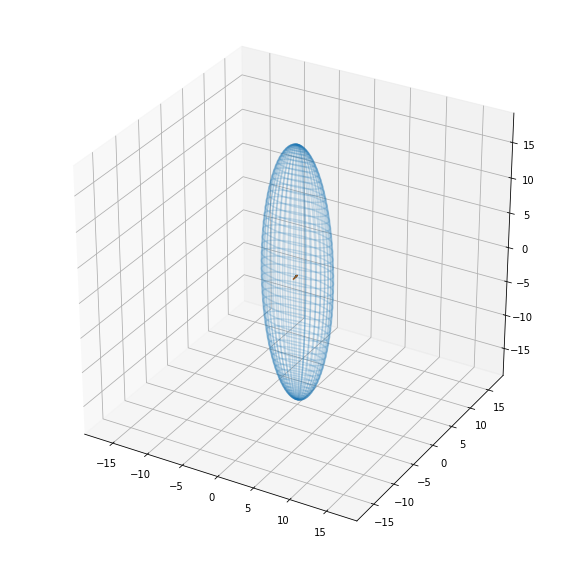

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

### WIREFRAME ###
xList = np.array(sampledPoints[0]['xList'])
xShifted = xList - (max(xList)+min(xList))/2
J = JCheb(xShifted,rho)
u,s,vt = np.linalg.svd(J)

theta = np.linspace(0, 2 * np.pi, 200)
phi = np.linspace(0, np.pi, 200)

radius = M*np.sqrt(4*len(xList)-3)
x = radius*np.outer(np.cos(theta), np.sin(phi))
y = radius*np.outer(np.sin(theta), np.sin(phi))
z = radius*np.outer(np.ones_like(theta), np.cos(phi))

x_rot = copy.deepcopy(x)
y_rot = copy.deepcopy(y)
z_rot = copy.deepcopy(z)

Jacob = np.dot(np.diag(s[0:3]),[[0,0,1],[0,1,0],[1,0,0]])
for i in range(len(x_rot)):
    for j in range(len(x_rot[0])):
        vect = [x_rot[i][j],y_rot[i][j],z_rot[i][j]]
        vect_rot = np.dot(Jacob,vect)
        x_rot[i][j] = vect_rot[1]
        y_rot[i][j] = vect_rot[2]
        z_rot[i][j] = vect_rot[0]

ax.plot_wireframe(x_rot, y_rot, z_rot, rstride=5, cstride=4, alpha=0.2,label='Bound from Chebychev')

### MODEL MANIFOLD ###

proj = np.dot([p['pointVals'] for p in sampledPoints],u)

pointsX = proj[:,1]
pointsY = proj[:,2]
pointsZ = proj[:,0]

ax.scatter3D(pointsX,pointsY,pointsZ,color='C1',edgecolors='black',s=1,linewidth=0.1,label='Model Predictions')

# Adjustment of the axes, so that they all have the same span:
max_radius = radius*s[0]
for axis in 'xyz':
    getattr(ax, 'set_{}lim'.format(axis))((-max_radius, max_radius))
#ax.view_init(0,0)
#ax.set_xlabel('first time point')
#ax.set_ylabel('second time point')
#ax.set_zlabel('third time point')

plt.show()
#trianglePlotBound(proj,['C1' for p in sampledPoints0],s,len(xList),dim=4)

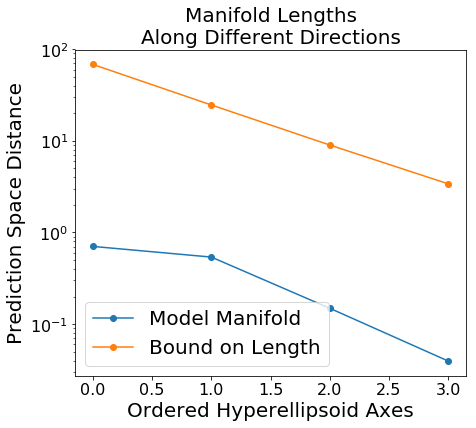

In [15]:
lengths = np.array([max(proj[:,i])-min(proj[:,i]) for i in range(proj.shape[1])])
blur = 4*M*rho**(1-len(xList))/(rho-1)
polyLengths = 2*radius*s
approxLengths = [2*M*np.sqrt(2*len(xList)**2-3*len(xList))*rho**(2-j)/np.sqrt(rho**2-1) + blur for j in range(len(xList))]

plt.figure(figsize=(7,6))
plt.plot([i for i in range(len(lengths))],lengths,label='Model Manifold',marker='o')
#plt.plot([i for i in range(len(polyLengths))],polyLengths,label=r'$\ell_j(H_P)$',marker='o')
plt.plot([i for i in range(len(approxLengths))],approxLengths,label='Bound on Length',marker='o')
plt.yscale('log')
#limits = np.array([min([min(x) for x in [lengths, polyLengths]]),max([max(x) for x in [lengths, polyLengths]])])
#plt.ylim(limits)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Ordered Hyperellipsoid Axes',fontsize=20)
plt.ylabel('Prediction Space Distance',fontsize=20)
plt.title('Manifold Lengths\nAlong Different Directions',fontsize=20)
plt.legend(fontsize=20,loc='lower left')
plt.show()

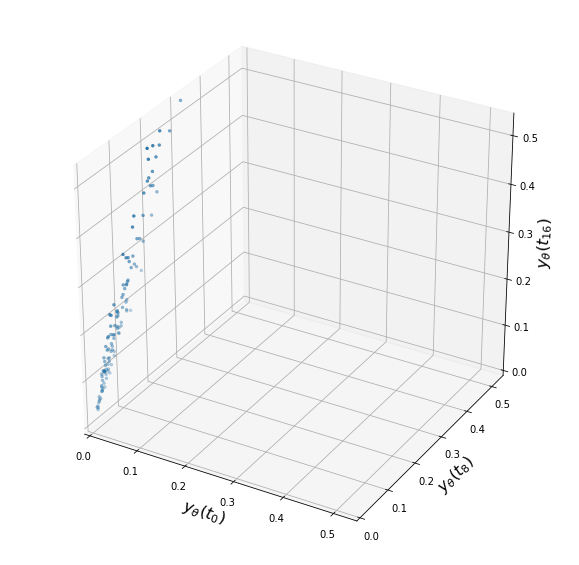

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

#proj = np.dot([p['pointVals'] for p in sampledPoints0],u)

allPoints = np.array([p['pointVals'] for p in sampledPoints])

pointsX = allPoints[:,0]
pointsY = allPoints[:,1]
pointsZ = allPoints[:,2]

ax.scatter3D(pointsX,pointsY,pointsZ,color='C0',edgecolors='black',s=10,linewidth=0.1,label='Model Predictions')

# Adjustment of the axes, so that they all have the same span:
max_radius = max([max(pointsX),max(pointsY),max(pointsZ)])
for axis in 'xyz':
    getattr(ax, 'set_{}lim'.format(axis))((0, max_radius))
#ax.view_init(0,0)
ax.set_xlabel(r'$y_{\theta}(t_{0})$',fontsize=16)
ax.set_ylabel(r'$y_{\theta}(t_{8})$',fontsize=16)
ax.set_zlabel(r'$y_{\theta}(t_{16})$',fontsize=16)

plt.show()
#trianglePlotBound(proj,['C1' for p in sampledPoints0],s,len(xList),dim=4)
#trianglePlot(allPoints,['C1' for p in sampledPoints0],dim=5)

In [17]:
hullPoints = np.array([pointsX,pointsY,pointsZ]).T
hull = ConvexHull(hullPoints)
tri = mtri.Triangulation(pointsX, pointsY, triangles=hull.simplices)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(pointsX,pointsY,pointsZ,color='C0',edgecolors='black',s=10,linewidth=0.1,label='Model Predictions with \nDifferent Parameters ('+r'$\theta$'+')')
ax.plot_trisurf(tri, pointsZ, color='C0',alpha=0.3)

for axis in 'xyz':
    getattr(ax, 'set_{}lim'.format(axis))((0, max_radius))

ax.set_xlabel(r'$y_{\theta}(t_{0})$',fontsize=20)
ax.set_ylabel(r'$y_{\theta}(t_{8})$',fontsize=20)
ax.set_zlabel(r'$y_{\theta}(t_{16})$',fontsize=20)

label1 = mlines.Line2D([], [], color='C0',marker='o',linewidth=0, markersize=10, label='Model Predictions at '+r'$(t_0,t_{8},t_{16})$'+'\nFor Different Model Parameters '+r'$(\theta)$')
plt.legend(handles=[label1],fontsize=20,loc = 'upper right')

plt.show()

QhullError: QH6013 qhull input error: input is less than 3-dimensional since it has the same x coordinate

While executing:  | qhull i Qt
Options selected for Qhull 2015.2.r 2016/01/18:
  run-id 1979774232  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 0.5  Error-roundoff 6.9e-16  _one-merge 4.8e-15
  _near-inside 2.4e-14  Visible-distance 1.4e-15  U-coplanar-distance 1.4e-15
  Width-outside 2.8e-15  _wide-facet 8.3e-15
